In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!echo '{"username":"kushgabani","key":"2d5beec462b167cbb153b799f07b04f1"}' > /root/.kaggle/kaggle.json
!kaggle datasets download -d kmader/parkinsons-drawings

 97% 40.0M/41.4M [00:00<00:00, 36.5MB/s]
100% 41.4M/41.4M [00:00<00:00, 60.6MB/s]


In [ ]:
!unzip /content/parkinsons-drawings.zip -d dataset

Archive:  /content/parkinsons-drawings.zip
  inflating: dataset/drawings/spiral/testing/healthy/V01HE01.png  
  inflating: dataset/drawings/spiral/testing/healthy/V02HE01.png  
  inflating: dataset/drawings/spiral/testing/healthy/V03HE1.png  
  inflating: dataset/drawings/spiral/testing/healthy/V04HE01.png  
  inflating: dataset/drawings/spiral/testing/healthy/V05HE01.png  
  inflating: dataset/drawings/spiral/testing/healthy/V06HE01.png  
  inflating: dataset/drawings/spiral/testing/healthy/V07HE01.png  
  inflating: dataset/drawings/spiral/testing/healthy/V08HE01.png  
  inflating: dataset/drawings/spiral/testing/healthy/V09HE01.png  
  inflating: dataset/drawings/spiral/testing/healthy/V10HE01.png  
  inflating: dataset/drawings/spiral/testing/healthy/V11HE01.png  
  inflating: dataset/drawings/spiral/testing/healthy/V55HE12.png  
  inflating: dataset/drawings/spiral/testing/healthy/V55HE13.png  
  inflating: dataset/drawings/spiral/testing/healthy/V55HE14.png  
  inflating: dataset

In [ ]:
%tensorflow_version 2.x
# Tools for working with directories
import os
import shutil

# Tools for data manipulation and EDA
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Tools for working with images
import cv2
from google.colab.patches import cv2_imshow

# Keras API for Neural Networks
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
%matplotlib inline

In [ ]:
# storing training and testing paths of the dataset

sp_training_path = "./dataset/spiral/training/"
wv_training_path = "./dataset/wave/training/"

sp_testing_path = "./dataset/spiral/testing/"
wv_testing_path = "./dataset/wave/testing/"

shutil.rmtree("./dataset/drawings")

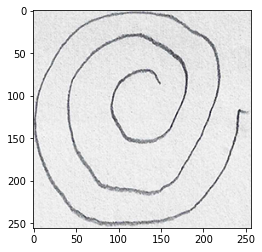

In [ ]:
# Plotting the images
img = mpimg.imread(sp_training_path + "healthy/V01HE03.png")
plt.imshow(img)

In [ ]:
# Dimension of input images 200 x 200
DIMENSIONS = 200

# Setting corresponding labels to numeric categories
# label_dict = {
#       "spiral_healthy" : 0,
#       "spiral_parkinson" : 1,
#       "wave_healthy" : 2,
#       "wave_parkinson" : 3
#   }

label_dict = {
      "healthy" : 0,
      "parkinson" : 1,
  }

# Initialising X_train, y_train, X_test, y_test
def get_training_testing_data():
  X_train = []
  y_train = []

  X_test = []
  y_test = []

  # Converting and resizing images in 200 x 200 and storing it in X_train and its corresponding labels in y_train
  for dir in [sp_training_path, sp_testing_path, wv_training_path, wv_testing_path]:
    for cat in ["healthy", "parkinson"]:
      for r, _, files in os.walk(dir + cat):
        for image in files:
          img = cv2.imread(dir + cat + "/" + image)
          img = cv2.resize(img, (DIMENSIONS, DIMENSIONS)) # Resizing the images
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting the image into RBG
          token = dir.split("/")

          # Storing spirals and waves in train and test lists
          if "training" in token:
            X_train.append(img) 
            y_train.append(label_dict[cat])
          else:
            X_test.append(img)
            y_test.append(label_dict[cat])
  # One Hot Encoding the labels of both training and testing samples
  y_train = to_categorical(y_train, 2)
  y_test = to_categorical(y_test, 2)

  return np.array(X_train), y_train, np.array(X_test), y_test

X_train, y_train, X_test, y_test = get_training_testing_data()

In [ ]:
# generate data samples in the minority class using data augmentation
def data_augmentation(X_train, y_train, X_test, y_test):
  datagen = ImageDataGenerator(brightness_range = [0.4, 1.0],
                              horizontal_flip = True,
                              vertical_flip = True,
                              rotation_range = 180,
                              rescale = 1.0/255.0)

  train_iterator = datagen.flow(x = X_train, y = y_train, batch_size = 32, shuffle=True)
  test_iterator = ImageDataGenerator(rescale = 1.0 / 255.0).flow(x = X_test, y = y_test, batch_size = 32, shuffle = False)
  return train_iterator, test_iterator

train_iterator, test_iterator = data_augmentation(X_train, y_train, X_test, y_test)

In [ ]:
input_shape = (DIMENSIONS, DIMENSIONS, 3)
# Creating the model
def create_model(opt = "adam"):
    model = Sequential([
                            Conv2D(32, (3, 3), activation = "relu", input_shape = input_shape), # First convolutional layer
                            MaxPool2D((2,2), 2),
                            Conv2D(64, (3, 3), activation = "relu"),  # Second convolutional layer
                            MaxPool2D((2,2), 2),
                            Conv2D(80, (3, 3), activation = "relu"),  # Third convolutional layer
                            Conv2D(80, (3, 3), activation = "relu"),  # Fourth convolutional layer
                            MaxPool2D((2,2), 2),
                            Conv2D(128, (3, 3), activation = "relu"), # Fifth convolutional layer
                            Conv2D(128, (3, 3), activation = "relu"), # Sixth convolutional layer
                            MaxPool2D((2,2), 2),
                            Conv2D(128, (3, 3), activation = "relu"), # Seventh convolutional layer
                            MaxPool2D((2,2), 2),
                            Flatten(),
                            Dense(40, activation = "relu"), # Hidden Layer
                            Dense(2, activation = "softmax") # Output layer
                      ])
    
    # Specifying Loss function, optimizer with learning rate and the evaluation metric
    model.compile(optimizer = Adam(lr = 3e-4),
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 80)        46160     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 80)        57680     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 80)        0

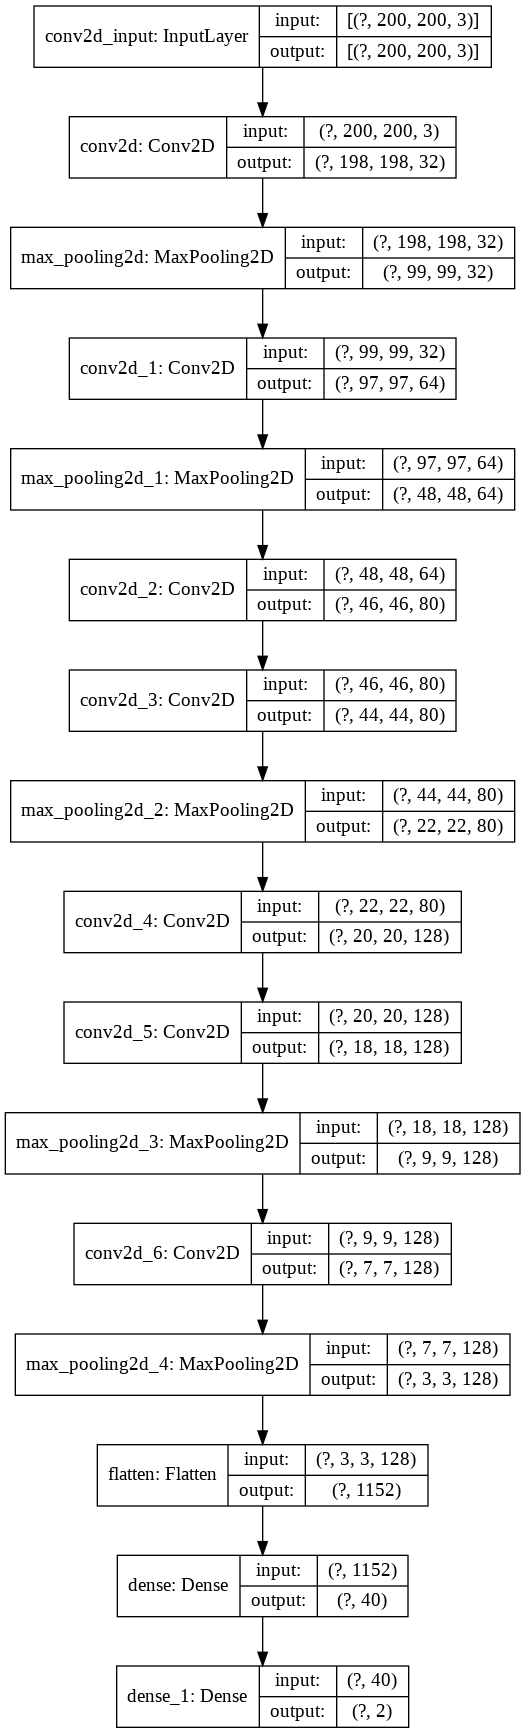

In [ ]:
# Plotting the CNN Architecture in a diagram
plot_model(model, show_shapes=True, show_layer_names = True)

In [ ]:
def train_model(model, epochs, batch_size):
  # Reducing learning rate when the model takes a flat road during training
  reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=0.0001,
                                verbose = 1,
                                mode = "min")
  
  # Training the model on the training set
  history = model.fit(train_iterator,
                      epochs = 250,
                      verbose = 1,
                      validation_data = test_iterator,
                      callbacks = [reduce_lr])
  return history

history = train_model(model, 250, train_iterator.n // train_iterator.batch_size)

Epoch 1/250
5/5 [==============================] - 2s 303ms/step - loss: 0.6941 - accuracy: 0.4792 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/250
5/5 [==============================] - 1s 261ms/step - loss: 0.6940 - accuracy: 0.4306 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/250
5/5 [==============================] - 1s 236ms/step - loss: 0.6943 - accuracy: 0.5000 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 4/250
5/5 [==============================] - 1s 232ms/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 5/250
5/5 [==============================] - 1s 264ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 6/250
5/5 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5000
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0001.
5/5 [==============================] - 1s 232ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/

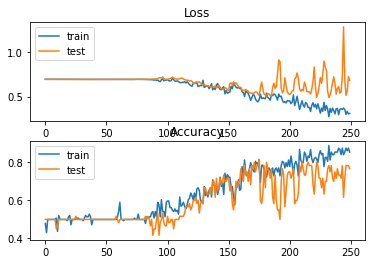

In [ ]:
def plot_loss_accuracy(history):
  # plot loss during training
  plt.subplot(211)
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  # plt.plot(history.history['val_loss'], label='validation')
  plt.legend()
  # plot accuracy during training
  plt.subplot(212)
  plt.title('Accuracy')
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  # plt.plot(history.history['val_accuracy'], label='validation')
  plt.legend()
  plt.show()

plot_loss_accuracy(history)

In [ ]:
# Checking the accuracy of the model
y_prediction = model.predict_generator(test_iterator)
pred_class = []
for pred in y_prediction:
  class_index = np.argmax(pred)
  quad_class_pred = list(label_dict.keys())[class_index]
  pred_class.append("health") if "healthy" in quad_class_pred else pred_class.append("parkinson")

actual_labels = []

for sample in y_test:
  i = np.where(sample == 1)[0][0]
  classes = list(label_dict.keys())
  actual_labels.append("healthy") if "healthy" in classes[i] else actual_labels.append("parkinson")

test_loss, test_acc = model.evaluate(test_iterator, verbose = 0)
print('Test accuracy: ' + str(test_acc))

Instructions for updating:
Please use Model.predict, which supports generators.
Test accuracy: 0.7666666507720947


In [ ]:
# Saving the model
model.save("parkinson-model", save_format = "h5")